In [1]:
!pip install tensorflow-macos
!pip install keras

  Using cached protobuf-3.19.6-py2.py3-none-any.whl (162 kB)
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy-1.23.4.dist-info/METADATA'



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

4 Random Training samples and labels


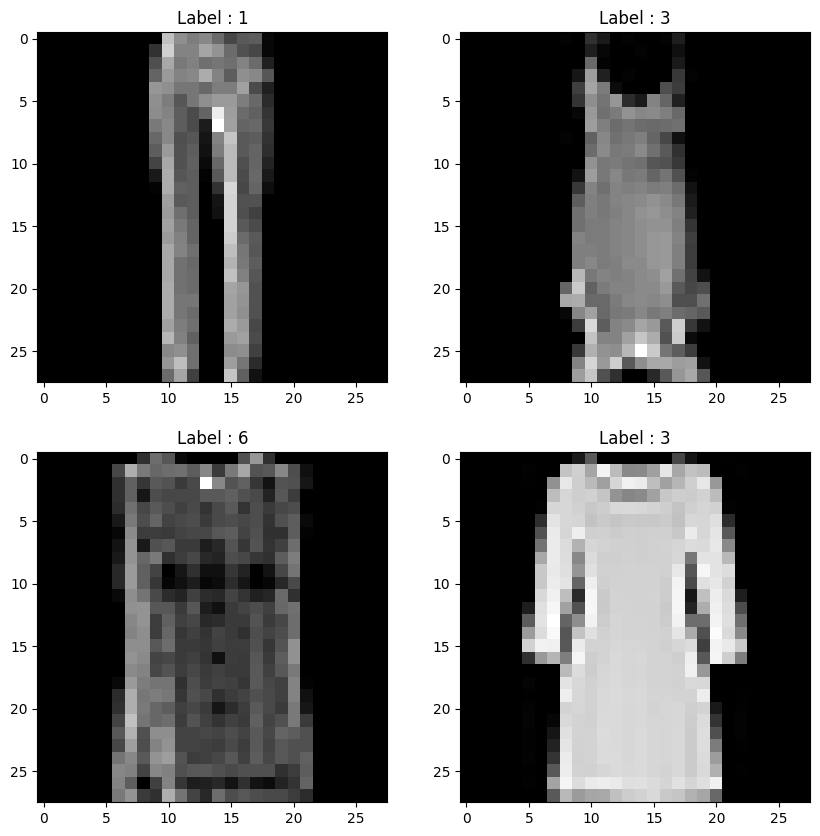

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

## Define `FFDense` custom layer

In this custom layer, we have a base `keras.layers.Dense` object which acts as the
base `Dense` layer within. Since weight updates will happen within the layer itself, we
add an `keras.optimizers.Optimizer` object that is accepted from the user. Here, we
use `Adam` as our optimizer with a rather higher learning rate of `0.03`.

Following the algorithm's specifics, we must set a `threshold` parameter that will be
used to make the positive-negative decision in each prediction. This is set to a default
of 2.0.
As the epochs are localized to the layer itself, we also set a `num_epochs` parameter
(defaults to 50).

We override the `call` method in order to perform a normalization over the complete
input space followed by running it through the base `Dense` layer as would happen in a
normal `Dense` layer call.

We implement the Forward-Forward algorithm which accepts 2 kinds of input tensors, each
representing the positive and negative samples respectively. We write a custom training
loop here with the use of `tf.GradientTape()`, within which we calculate a loss per
sample by taking the distance of the prediction from the threshold to understand the
error and taking its mean to get a `mean_loss` metric.

With the help of `tf.GradientTape()` we calculate the gradient updates for the trainable
base `Dense` layer and apply them using the layer's local optimizer.

Finally, we return the `call` result as the `Dense` results of the positive and negative
samples while also returning the last `mean_loss` metric and all the loss values over a
certain all-epoch run.

In [ ]:
class ConvLayer(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Convolution layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        optimizer,
        loss_metric,
        num_epochs=60,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.conv2d = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Convolution
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=-1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.conv2d(x_dir)
        return keras.activations.softmax(res)

    # The Forward-Forward algorithm is below. We first perform the Convolution-layer
    # operation and then get a negative log likelihood value for all positive and negative
    # samples respectively.
    # The custom loss function finds the mean of the negative log likelihood
    # values and adds it to the loss metric.
    # Once the loss is calculated, we get a mean across the entire batch combined and
    # perform a gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x, y):
        x_norm = tf.norm(x, ord=2, axis=-1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.conv2d(x_dir)
        res = keras.activations.softmax(res)
        loss = 0
        for i in range(len(res)):
            pos = res[i][y[i]]
            neg = 0
            for j in range(len(res[i])):
                if j != y[i]:
                    neg += res[i][j]
            loss += -tf.math.log(pos) - tf.math.log(neg)
        loss = loss / len(res)
        self.loss_metric(loss)
        return loss


## Define the `FFNetwork` Custom Model

With our custom layer defined, we also need to override the `train_step` method and
define a custom `keras.models.Model` that works with our `FFDense` layer.

For this algorithm, we must 'embed' the labels onto the original image. To do so, we
exploit the structure of MNIST images where the top-left 10 pixels are always zeros. We
use that as a label space in order to visually one-hot-encode the labels within the image
itself. This action is performed by the `overlay_y_on_x` function.

We break down the prediction function with a per-sample prediction function which is then
called over the entire test set by the overriden `predict()` function. The prediction is
performed here with the help of measuring the `excitation` of the neurons per layer for
each image. This is then summed over all layers to calculate a network-wide 'goodness
score'. The label with the highest 'goodness score' is then chosen as the sample
prediction.

The `train_step` function is overriden to act as the main controlling loop for running
training on each layer as per the number of epochs per layer.

In [5]:

# implement a forward-forward network using the forward forward convolution using the class ConvLayer defined above
class FFNetwork(keras.Model):
    def __init__(self, optimizer, loss_metric, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = ConvLayer(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            optimizer=optimizer,
            loss_metric=loss_metric,
        )
        self.conv2 = ConvLayer(
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same",
            optimizer=optimizer,
            loss_metric=loss_metric,
        )
        self.conv3 = ConvLayer(
            filters=128,
            kernel_size=3,
            strides=2,
            padding="same",
            optimizer=optimizer,
            loss_metric=loss_metric,
        )
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(128, activation="relu")
        self.dense2 = keras.layers.Dense(10, activation="softmax")

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

    def forward_forward(self, x, y):
        # execute the forward-forward algorithm for the convolution layers
        x = self.conv1.forward_forward(x, y)
        x = self.conv2.forward_forward(x, y)
        x = self.conv3.forward_forward(x, y)
        # execute the forward-forward algorithm for the dense layers
        x = self.dense1.forward_forward(x, y)
        x = self.dense2.forward_forward(x, y)
        return x
    



## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [6]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-13 09:53:22.480322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 09:53:22.480468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# find the dimensions of our images
img_width, img_height = x_train.shape[1], x_train.shape[2]
print(f"Image dimensions are {img_width} x {img_height}")

Image dimensions are 28 x 28


## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [8]:
def custom_loss(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true)/K.clip(K.square(0.01*y_pred), K.epsilon(), None), axis=-1)

In [9]:
# model = FFNetwork(dims=[400, 250, 250])

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.06),
#     loss= custom_loss, #"mse",
#     jit_compile=True,
#     metrics=[keras.metrics.Mean()],
# )

# epochs = 300
# history = model.fit(train_dataset, epochs=epochs)

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

In [10]:
# preds = model.predict(tf.convert_to_tensor(x_test))

# preds = preds.reshape((preds.shape[0], preds.shape[1]))

# results = accuracy_score(preds, y_test)

# print(f"Test Accuracy score : {results*100}%")

# plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
# plt.title("Loss over training")
# plt.show()

## Conclusion

This example has hereby demonstrated how the Forward-Forward algorithm works using
the TensorFlow and Keras packages. While the investigation results presented by Prof. Hinton
in their paper are currently still limited to smaller models and datasets like MNIST and
Fashion-MNIST, subsequent results on larger models like LLMs are expected in future
papers.

Through the paper, Prof. Hinton has reported results of 1.36% test accuracy error with a
2000-units, 4 hidden-layer, fully-connected network run over 60 epochs (while mentioning
that backpropagation takes only 20 epochs to achieve similar performance). Another run of
doubling the learning rate and training for 40 epochs yields a slightly worse error rate
of 1.46%

The current example does not yield state-of-the-art results. But with proper tuning of
the Learning Rate, model architecture (number of units in `Dense` layers, kernel
activations, initializations, regularization etc.), the results can be improved
to match the claims of the paper.

In [17]:
class FFConv2D(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Conv2D layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        filters,
        kernel_size,
        optimizer,
        loss_metric,
        num_epochs=60,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.conv2d = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    def call(self, x):
        res = self.conv2d(x)
        return self.relu(res)

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(
                    tf.math.pow(self.call(x_pos), 2), [1, 2, 3])
                g_neg = tf.math.reduce_mean(
                    tf.math.pow(self.call(x_neg), 2), [1, 2, 3])

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold,
                                  g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.conv2d.trainable_weights)
            self.optimizer.apply_gradients(
                zip(gradients, self.conv2d.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


In [19]:
# create the model

loss_metric = keras.metrics.Mean(name="loss")
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model = FFConvModel(dims=[784],loss_metric=loss_metric,optimizer=optimizer)

# compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [20]:
print(x_train.shape)

(60000, 28, 28)


In [21]:
# train the model
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10


2023-04-13 09:53:24.040288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Passing layer 1 now : 
(None, 28, 28, 32)
(None, 28, 28, 32)
Passing layer 2 now : 
Passing layer 3 now : 
Passing layer 1 now : 
(None, 28, 28, 32)
(None, 28, 28, 32)
Passing layer 2 now : 
Passing layer 3 now : 


2023-04-13 09:53:24.545037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-13 09:53:24.598247: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at xla_ops.cc:296 : UNIMPLEMENTED: Could not find compiler for platform METAL: NOT_FOUND: could not find registered compiler for platform METAL -- was support for that platform linked in?


UnimplementedError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/9z/rzhqtj2d2bl2tcv7_p857byr0000gn/T/ipykernel_50575/26878198.py", line 2, in <module>
      model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
Node: 'StatefulPartitionedCall'
Could not find compiler for platform METAL: NOT_FOUND: could not find registered compiler for platform METAL -- was support for that platform linked in?
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_635]